In [1]:
import json
# import ast

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from catboost import CatBoostClassifier, Pool, metrics, EFeaturesSelectionAlgorithm
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
# from transformers import AutoTokenizer
# import torch
import shap

from pandarallel import pandarallel
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # to manipulate x-tickers
import plotly.express as px
from Levenshtein import distance as lev_distance

import os
from tqdm import tqdm
import random
from collections import Counter
import pickle
import warnings

from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize': (20, 10), 'figure.facecolor': 'white'})
sns.set_palette("viridis")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
os.environ["TOKENIZERS_PARALLELISM"] = "true"  # activate parallelism
pandarallel.initialize(progress_bar=True)
InteractiveShell.ast_node_interactivity = "all"  # show all outputs, not only the last

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [82]:
data = pd.read_csv("../data/raw/train_dataset_Самолет.csv")

In [98]:
# data

In [ ]:
# delete nearly null features
data

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


seed_everything()

In [4]:
def get_column_indices(df: pd.DataFrame, column_names: list) -> list:
    return [df.columns.get_loc(c) for c in column_names if c in df.columns]

In [5]:
def plot_roc_curve(model, X_test, y_test):
    # Predict probabilities for the test data.
    y_probs = model.predict_proba(X_test)

    # Keep only the positive class
    y_probs = y_probs[:, 1]

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Feature Engineering 

In [6]:
def create_features(data):
    data['day'] = pd.to_datetime(data['report_date']).dt.day
    data['week'] = pd.to_datetime(data['report_date']).dt.week
    data['weekday'] = pd.to_datetime(data['report_date']).dt.weekday
    data['month'] = pd.to_datetime(data['report_date']).dt.month
    data['year'] = pd.to_datetime(data['report_date']).dt.year
    return data

In [84]:
data = create_features(data)

In [9]:
set(data.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

In [ ]:
# plot data
data[['client_id', 'target']].groupby('client_id').

In [89]:
X = data.drop(columns=['target', 'client_id', 'report_date'])
Y = data['target']

In [90]:
categorical_columns = X.select_dtypes(exclude=['float64', 'int64']).columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns

In [91]:
X[numerical_columns] = X[numerical_columns].fillna(0)

In [92]:
X[categorical_columns] = X[categorical_columns].astype(str)

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.33, random_state=42, shuffle=True)

# Model

In [94]:
def catboost_model_classifier(x_train, x_test, y_train, y_test):
    # categorical_features_indices = np.where(~X_train.dtypes.isin(['float64', 'int64']))[0]
    categorical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(x_train, categorical_columns)

    cb_model = CatBoostClassifier(
        loss_function='Logloss',
        random_seed=42,
        logging_level='Silent',
        # custom_metric=['MAE', 'MAPE'],
        max_depth=8,
        iterations=200,
        # scale_pos_weight=26,
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
        # eval_metric=[metrics.Precision(), metrics.Recall(), metrics.F1(), metrics.TotalF1(), metrics.Accuracy()]
    )

    cb_model.fit(
        x_train, y_train,
        eval_set=(x_test, y_test),
        cat_features=categorical_features_indices,
        plot=True
    )

    return cb_model


In [95]:
def get_feature_importances(X, y, model):
    # Add a random feature
    X['random'] = np.random.random(size=len(X))

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Get feature importances
    importances = model.feature_importances_

    # Create a dictionary that maps feature names to their importances
    feature_importances = {name: importance for name, importance in zip(X.columns, importances)}

    return feature_importances

In [96]:
model = catboost_model_classifier(X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [97]:
y_pred = model.predict(X_valid)

In [68]:
roc_auc_score(y_valid, y_pred)

0.9257990867579907

<Figure size 1200x1000 with 0 Axes>

<Axes: xlabel='Importances', ylabel='Feature Id'>

Text(0.5, 1.0, 'CatBoost features importance:')

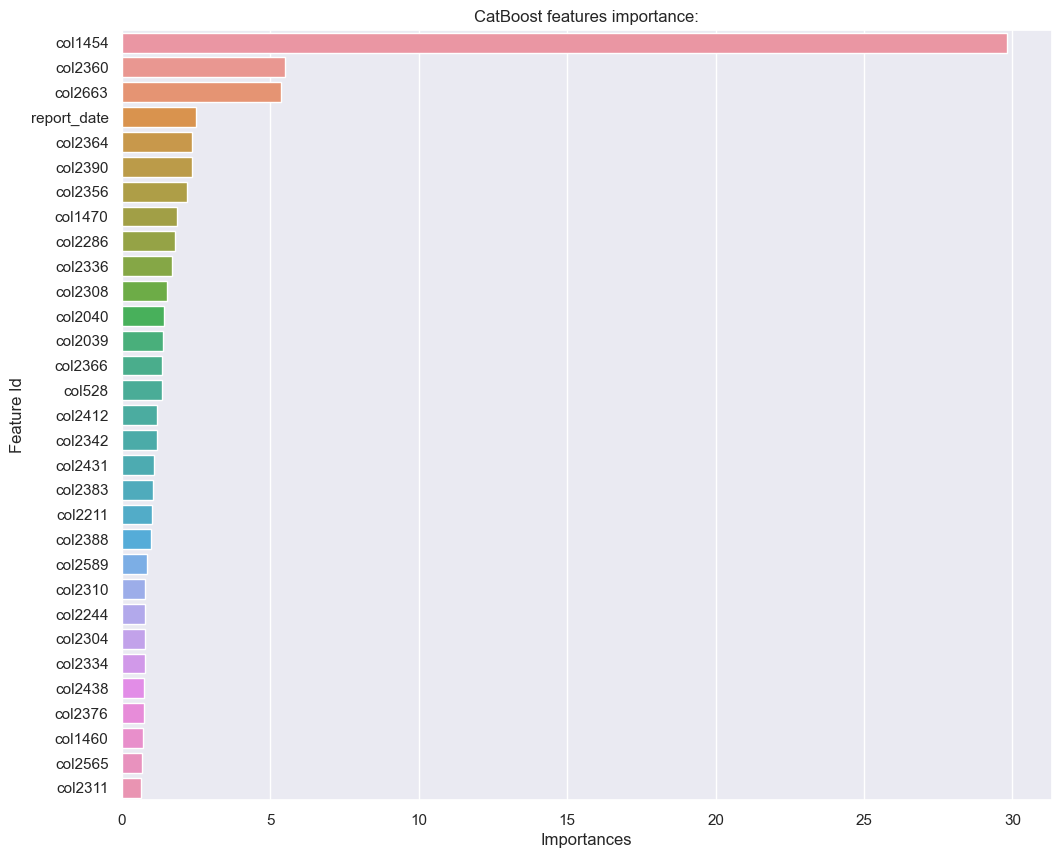

In [69]:
feat_importances = model.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:30, :])
plt.title('CatBoost features importance:')

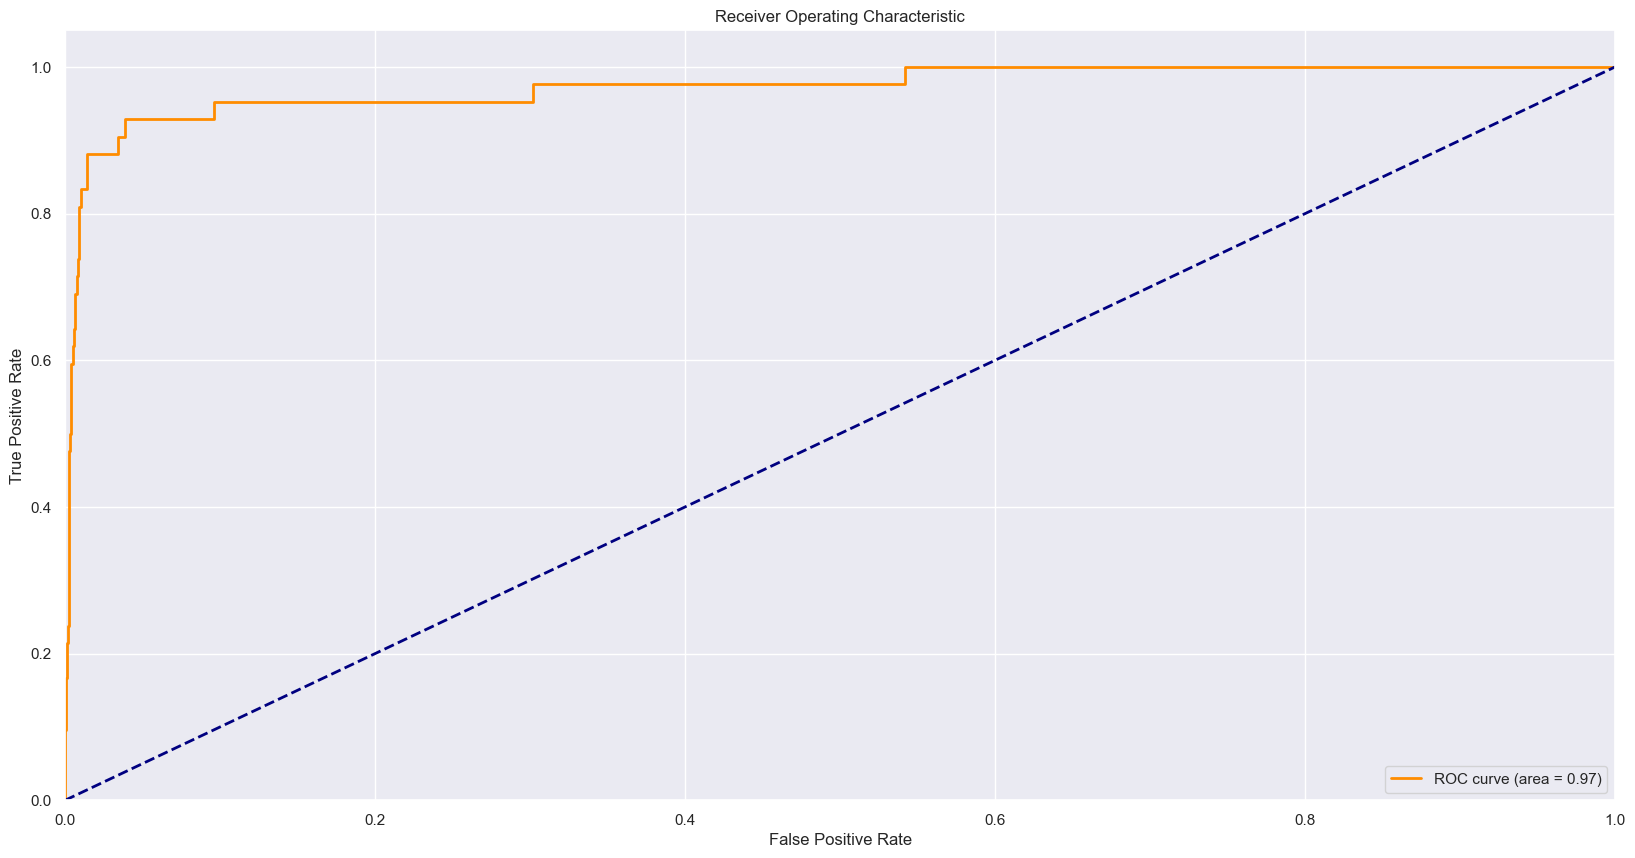

In [70]:
plot_roc_curve(model, X_valid, y_valid)

# Feature Selection

# Option 1

In [71]:
perm_raw = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=10)

In [72]:
perm = (
    pd.DataFrame(columns=['AVG_Importance', 'STD_Importance'], index=[i for i in X_train.columns])
    .assign(AVG_Importance=perm_raw.importances_mean)
    .assign(STD_Importance=np.std(perm_raw.importances, axis=1))
    .sort_values(by='AVG_Importance', ascending=False)
)

<Axes: ylabel='AVG_Importance'>

([], [])

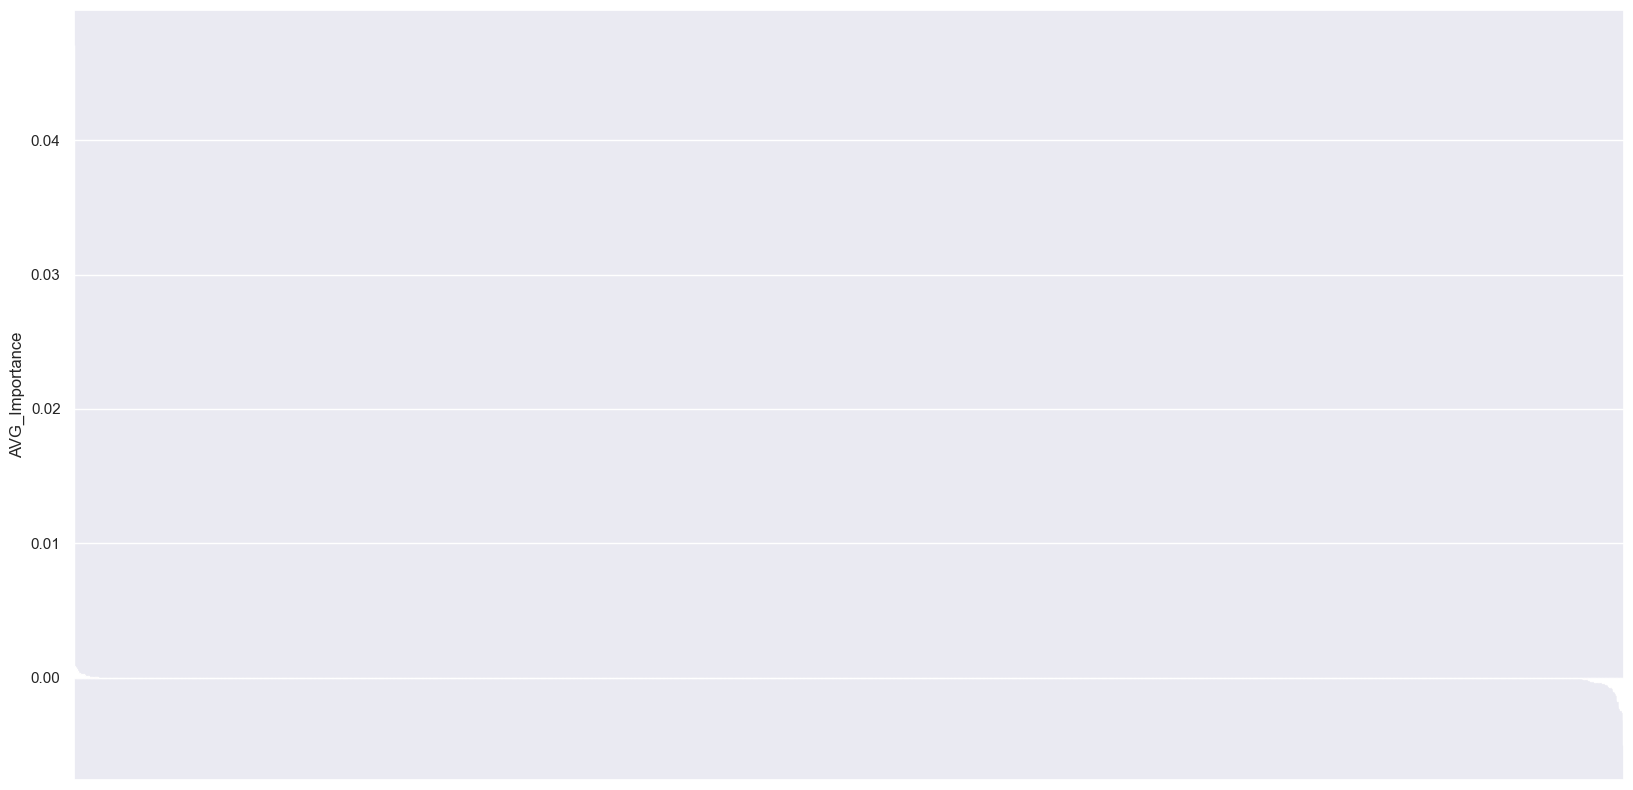

In [73]:
sns.barplot(x=perm.index, y=perm.AVG_Importance)
plt.xticks([])
plt.show()

In [74]:
perm

,AVG_Importance,STD_Importance
col1454,0.047090,0.002119
col104,0.000876,0.000188
col2039,0.000782,0.000509
col2336,0.000782,0.000730
col2214,0.000657,0.000452
...,...,...
col2340,-0.002378,0.000782
col2376,-0.002441,0.000653
col2040,-0.002534,0.000568
col2663,-0.003160,0.001301


In [75]:
perm.query("AVG_Importance > 0")["AVG_Importance"]

col1454        0.047090
col104         0.000876
col2039        0.000782
col2336        0.000782
col2214        0.000657
col2171        0.000594
col176         0.000532
col604         0.000501
col528         0.000344
col2001        0.000344
col216         0.000313
col584         0.000313
col324         0.000313
col2590        0.000313
col2118        0.000282
col2588        0.000250
col547         0.000250
col2622        0.000250
report_date    0.000219
col2468        0.000156
col2310        0.000156
col572         0.000156
col2211        0.000125
col96          0.000094
col2356        0.000094
col2238        0.000094
col408         0.000063
col565         0.000063
col184         0.000063
col2662        0.000063
col2341        0.000063
col2397        0.000063
col2278        0.000031
col100         0.000031
col952         0.000031
col654         0.000031
col1040        0.000031
col1180        0.000031
col188         0.000031
col636         0.000031
col2195        0.000031
col2294        0

Let's leave only useful features

In [76]:
perm.query("AVG_Importance > 0")["AVG_Importance"].index.to_list()

['col1454',
 'col104',
 'col2039',
 'col2336',
 'col2214',
 'col2171',
 'col176',
 'col604',
 'col528',
 'col2001',
 'col216',
 'col584',
 'col324',
 'col2590',
 'col2118',
 'col2588',
 'col547',
 'col2622',
 'report_date',
 'col2468',
 'col2310',
 'col572',
 'col2211',
 'col96',
 'col2356',
 'col2238',
 'col408',
 'col565',
 'col184',
 'col2662',
 'col2341',
 'col2397',
 'col2278',
 'col100',
 'col952',
 'col654',
 'col1040',
 'col1180',
 'col188',
 'col636',
 'col2195',
 'col2294']

In [78]:
useful_column_indices = get_column_indices(X_train, perm.query("AVG_Importance > 0")["AVG_Importance"].index.to_list())

In [79]:
model_without_noise_feat = catboost_model_classifier(X_train.iloc[:, useful_column_indices],
                                                     X_test.iloc[:, useful_column_indices], y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [80]:
y_pred = model_without_noise_feat.predict(X_valid.iloc[:, useful_column_indices])
roc_auc_score(y_valid, y_pred)

0.9029680365296804

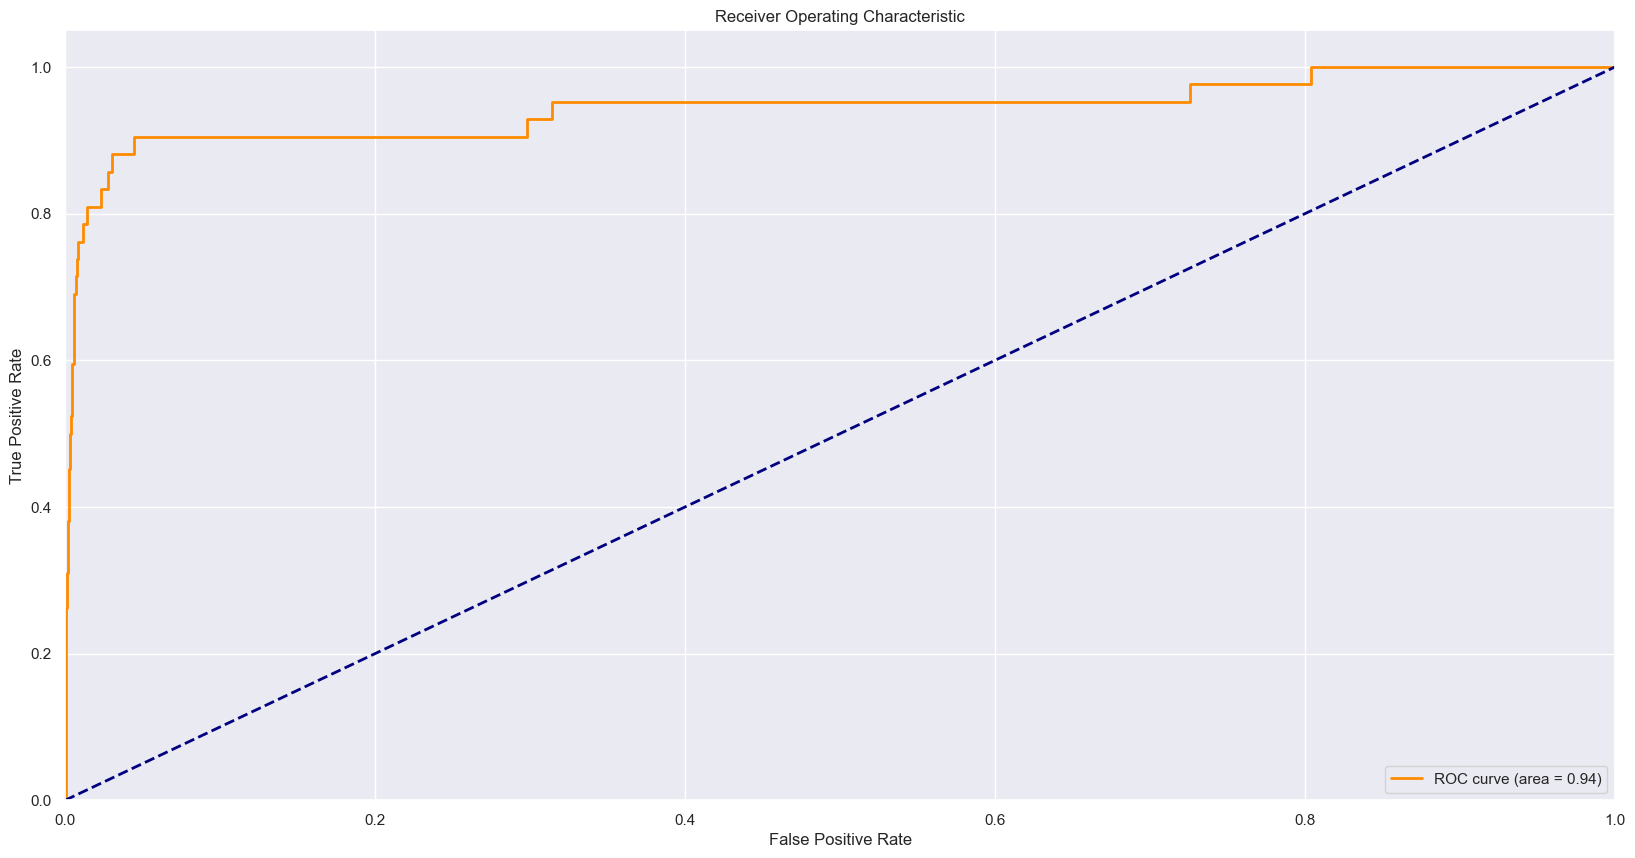

In [81]:
plot_roc_curve(model_without_noise_feat, X_valid.iloc[:, useful_column_indices], y_valid)

# Option 2

In [ ]:
model.select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    train_final_model=True,
    logging_level='Silent',
    plot=True,
)

# Hyperparameters Tuning

In [ ]:
def objective(search_space):  #x_train, x_test, y_train, y_test, 
    categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
    categorical_features_indices = get_column_indices(X_train, categorical_columns)

    cb_model = CatBoostClassifier(
        **search_space,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        early_stopping_rounds=20,
        random_seed=42,
    )

    cb_model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        cat_features=categorical_features_indices,
        plot=True,
        verbose=False
    )
    return {'loss': cb_model.get_best_score()['validation']['Logloss'], 'status': STATUS_OK}

In [ ]:
search_space = {
    'learning_rate': hp.uniform('learning_rate', 0.1, 0.5),
    'iterations': hp.randint('iterations', 100, 1000),
    'l2_leaf_reg': hp.randint('l2_leaf_reg', 1, 10),
    'depth': hp.randint('depth', 4, 10),
    # 'border_count': hp.uniform ('border_count', 32, 255),
}

In [ ]:
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    # verbose=False,
)

In [ ]:
hyperparams = space_eval(search_space, best_params)

In [ ]:
with open('hyperparams.pkl', 'wb') as fp:
    pickle.dump(hyperparams, fp)

In [ ]:
params = {
    'learning_rate': hyperparams['learning_rate'],
    'iterations': hyperparams['iterations'],
    'depth': hyperparams['depth'],
    'loss_function': 'Logloss',
    'l2_leaf_reg': hyperparams['l2_leaf_reg'],
    'eval_metric': 'Logloss',
    'early_stopping_rounds': 20,
    'random_seed': 42,
}

In [ ]:
categorical_columns = X_train.select_dtypes(exclude=['float64', 'int64']).columns
categorical_features_indices = get_column_indices(X_train, categorical_columns)
model = CatBoostClassifier(**params)
model.fit(X=X_train, y=y_train, eval_set=(X_valid, y_valid), verbose=250, cat_features=categorical_features_indices)
y_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_pred)

# Cross-Validation

In [ ]:
from catboost import cv

# parameters for training inside cv:
params = {
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}

In [ ]:
def print_cv_summary(cv_data):
    cv_data.head(10)

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )


In [ ]:
train_pool = Pool(data=X_train, label=y_train, cat_features=get_column_indices(X_train, categorical_columns))
val_pool = Pool(data=X_valid, label=y_valid, cat_features=get_column_indices(X_valid, categorical_columns))

In [ ]:
cv_data = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

print_cv_summary(cv_data)

In [ ]:
cv_data

# Validation